In [114]:
import copy
from linearmodels.iv import IV2SLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.signal
import scipy.stats
#import sysidentpy as sipy
from scipy.fft import fft, ifft, fftshift
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mutual_info_score

from sysidentpy.metrics import mean_squared_error
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from IPython.display import display, HTML
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error

plt.rc('font', size=30)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=25)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)    # fontsize of the tick labels
plt.rc('legend', fontsize=25)    # legend fontsize
plt.rc('lines', linewidth=3)     # linewidth

df1 = pd.read_csv('data/U3.ASC', sep="\s+", names=['time', 'y', 'u'])
df2 = pd.read_csv('data/U1.ASC', sep="\s+", names=['time', 'y', 'u'])

# cut
df1 = df1.iloc[301:1500]
df2 = df2.iloc[301:930]

# z-normalise
joint_avg_u = np.average(df1['u'].append(df2['u']))
joint_avg_y = np.average(df1['y'].append(df2['y']))
joint_std_u = np.std(df1['u'].append(df2['u']))
joint_std_y = np.std(df1['y'].append(df2['y']))
df1['u'] = (df1['u']-joint_avg_u)/joint_std_u
df1['y'] = (df1['y']-joint_avg_y)/joint_std_y
df2['u'] = (df2['u']-joint_avg_u)/joint_std_u
df2['y'] = (df2['y']-joint_avg_y)/joint_std_y

# u_train = np.asarray(df2['u']).reshape(-1, 1)
# u_valid = np.asarray(df1['u']).reshape(-1, 1)
# y_train = np.asarray(df2['y']).reshape(-1,1)
# y_valid = np.asarray(df1['y']).reshape(-1,1)

/tmp/ipykernel_760/4270553456.py:42: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_u = np.average(df1['u'].append(df2['u']))
/tmp/ipykernel_760/4270553456.py:43: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_avg_y = np.average(df1['y'].append(df2['y']))
/tmp/ipykernel_760/4270553456.py:44: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_u = np.std(df1['u'].append(df2['u']))
/tmp/ipykernel_760/4270553456.py:45: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  joint_std_y = np.std(df1['y'].append(df2['y']))


## Prepare data
### (Comment: when creating the lagged data we drop some values in $y$ and $u$ and thus loose the characteristic spectrum of PRBS. If instead of cutting the table short, we loop it (so that the we retain the full PRSB signal, we get a very similar performance).

In [115]:
# make a copy of the training and test data
df_2 = copy.deepcopy(df2)
df_1 = copy.deepcopy(df1)

# define lags
lag = 10

# create a list of labels
lagged_u = ['u_lag'+str(i) for i in range(1, lag+1)]
lagged_y = ['y_lag'+str(i) for i in range(1, lag+1)]

# adding lags to the dataset
for i in range(1, lag+1):
    df_2['u_lag' + str(i)] = df_2['u'].shift(i)
for i in range(1, lag+1):
    df_1['u_lag' + str(i)] = df_1['u'].shift(i)
for i in range(1, lag+1):
    df_2['y_lag' + str(i)] = df_2['y'].shift(i)
for i in range(1, lag+1):
    df_1['y_lag' + str(i)] = df_1['y'].shift(i)

# dropping NA values (created due to shifting)
df_2 = df_2.dropna()
df_1 = df_1.dropna()

In [124]:
X = df_2[lagged_u]
y = df_2['y']

model = auto_arima(y=y.iloc[:500], X=X.iloc[:500], d=0, seasonal=False,
                   error_action='ignore', suppress_warnings=True,
                   start_p=1, max_p=lag, start_q = 1, max_q=lag, trace=True)

print(model.params())

u_lag1    -0.010213
u_lag2    -0.003395
u_lag3     0.022605
u_lag4     0.050292
u_lag5     0.063362
u_lag6     0.069414
u_lag7     0.059782
u_lag8     0.055510
u_lag9     0.036727
u_lag10    0.021363
ar.L1      1.685274
ar.L2     -0.037549
ar.L3     -1.151523
ar.L4      0.499150
sigma2     0.001059
dtype: float64


Train RMSE: 0.038183272143685165


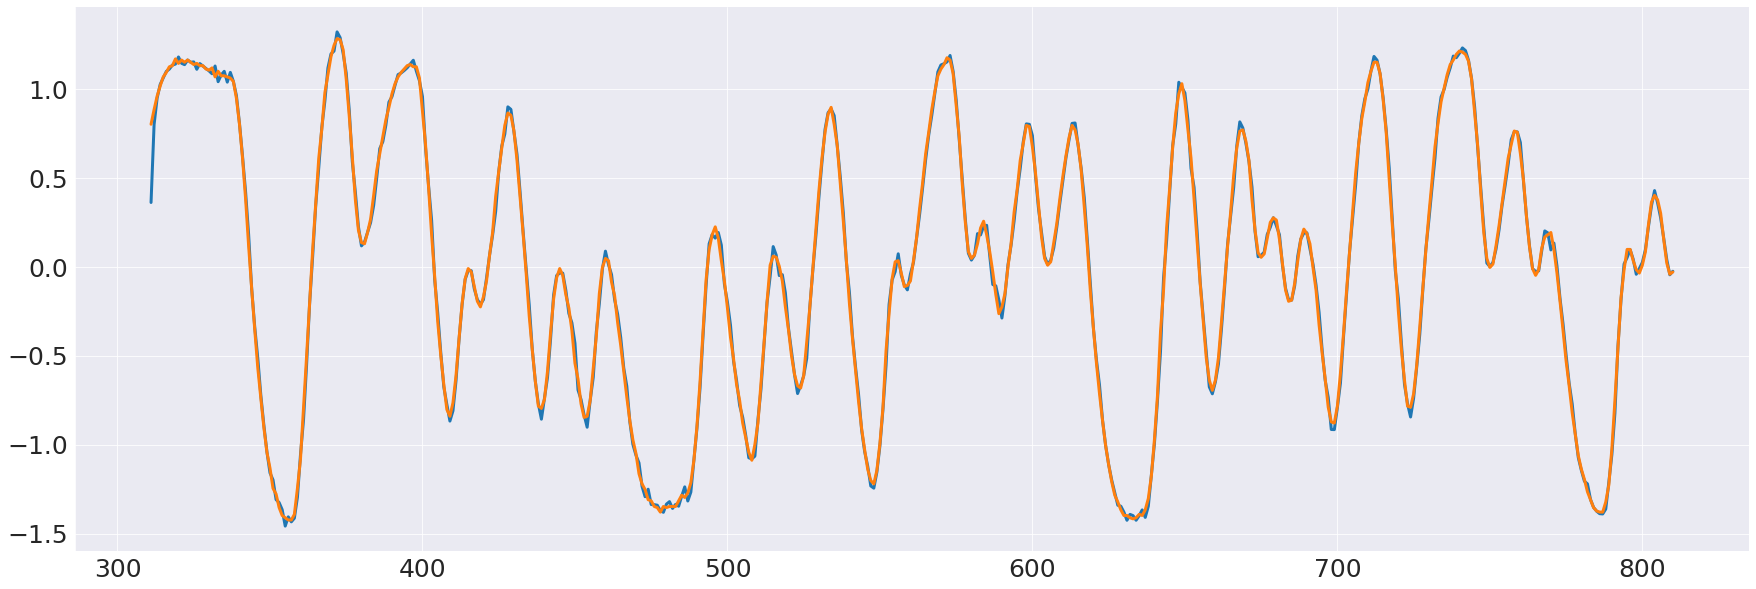

<Figure size 2160x720 with 0 Axes>

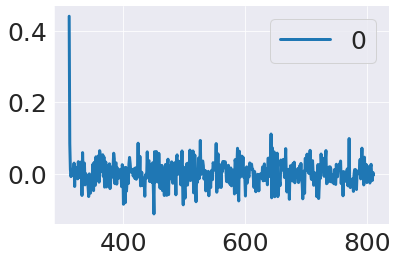

/home/kreljo/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


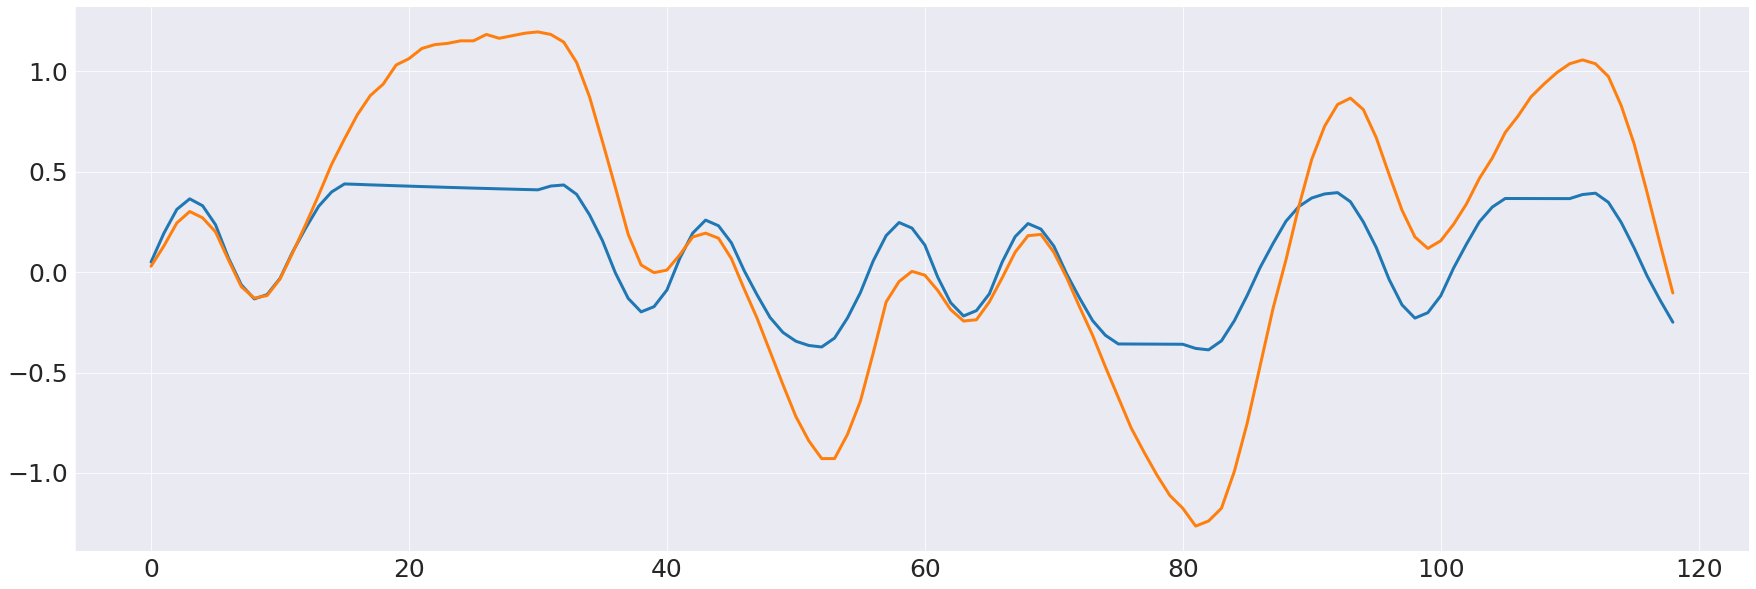

In [125]:
# Generate predictions
train_preds = model.predict_in_sample(X=X.iloc[:500])

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(df_2['y'].iloc[:500], train_preds))

print(f'Train RMSE: {train_rmse}')

# Plot train predictions
plt.figure(figsize=(30,10))
plt.plot(train_preds)
plt.plot(df_2['y'].iloc[:500])
plt.show()

# Plot residuals
plt.figure(figsize=(30,10))
residuals = pd.DataFrame(model.resid())
residuals.plot()
plt.show()

test_preds = model.predict(X=X.iloc[500:], n_periods=len(X)-500)
# Plot train predictions
plt.figure(figsize=(30,10))
plt.plot(np.asarray(test_preds))
plt.plot(np.asarray(df_2['y'].iloc[500:]))
plt.show()

y_lag1     0.676321
y_lag2     0.555808
y_lag3     0.409923
y_lag4     0.283067
y_lag5     0.143525
y_lag6     0.029355
y_lag7    -0.053102
y_lag8    -0.122873
y_lag9    -0.122873
y_lag10   -0.135559
Name: 311, dtype: float64
        u_lag1    u_lag2    u_lag3    u_lag4    u_lag5    u_lag6    u_lag7  \
311   0.993457  0.993457  0.993457  0.993457  0.993457  0.993457  0.993457   
312   0.993457  0.993457  0.993457  0.993457  0.993457  0.993457  0.993457   
313   0.993457  0.993457  0.993457  0.993457  0.993457  0.993457  0.993457   
314   0.993457  0.993457  0.993457  0.993457  0.993457  0.993457  0.993457   
315   0.993457  0.993457  0.993457  0.993457  0.993457  0.993457  0.993457   
...        ...       ...       ...       ...       ...       ...       ...   
1495 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586   
1496 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586   
1497 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.006586 -1.0065

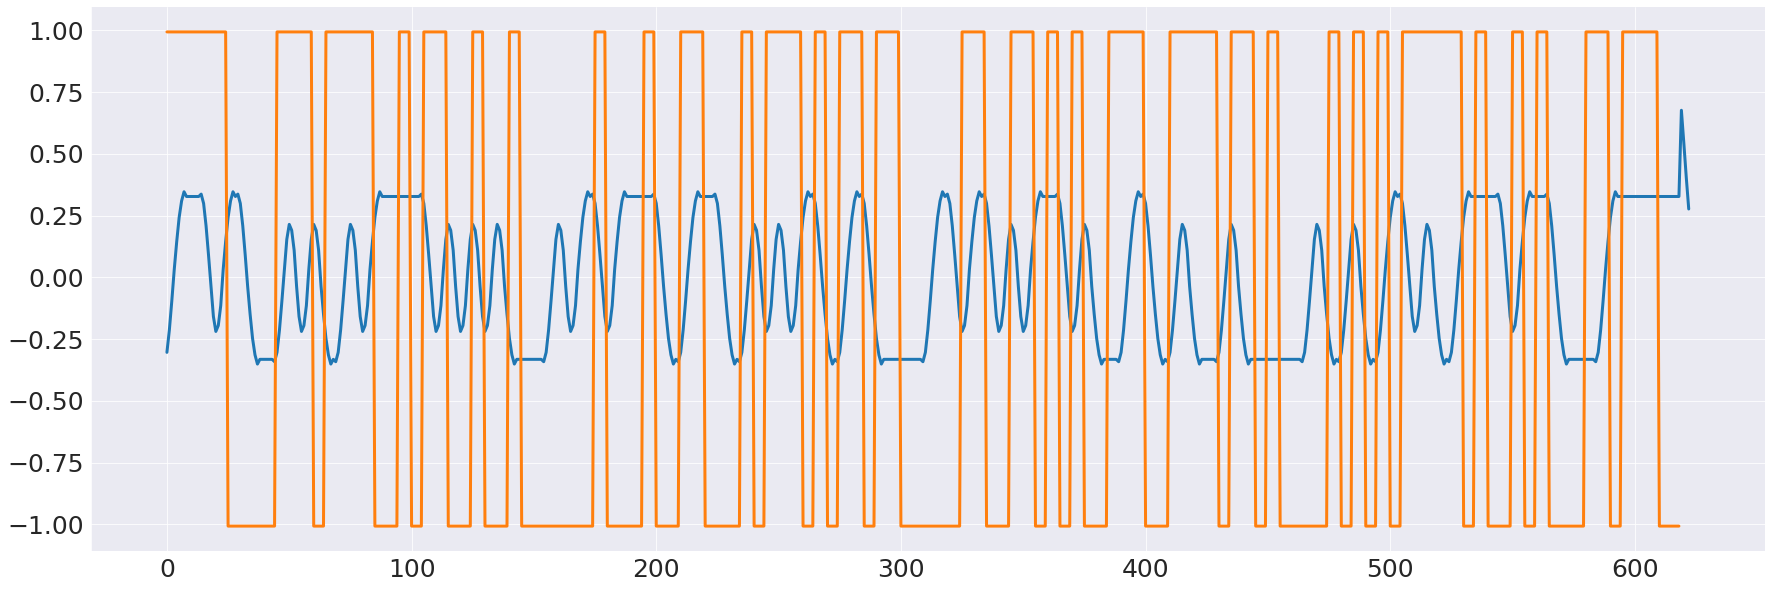

In [113]:
def simulate_arima_manual(p,q,y_init, u, coeffs, steps):
    """
    Manually simulates an ARIMA model.

    Parameters:
    y_init: The initial conditions for the endogenous variable.
    u: The exogenous variables for the simulation.
    coeffs: The coefficients of the ARIMA model.
    steps: The number of steps to simulate.

    Returns:
    A list with the simulated values.
    """

    # Initialize the simulated values with the initial conditions
    y_sim = list(y_init)[:p]
    e_sim = [np.sqrt(coeffs['sigma2']) for i in range(q)]  # Assume initial errors are 0

    print(y_sim)


    # For each step in the simulation
    for t in range(steps):

        # Compute the AR part
        ar = 0#sum(coeffs[f'ar.L{i+1}'] * y_sim[i] for i in range(0, p))

        # Compute the MA part
        ma = 0#sum(coeffs[f'ma.L{i+1}'] * e_sim[i] for i in range(0, q))

        # Compute the exogenous part
        exog = sum(coeffs[f'u_lag{i+1}'] * u.iloc[t,i] for i in range(0, lag))

        # Compute the prediction and error
        y_pred = ar + ma + exog
        e_pred = np.random.normal(0, np.sqrt(coeffs['sigma2']))

        # Append the prediction and error to the simulated values
        y_sim = np.concatenate(([y_pred],y_sim))
        e_sim = np.concatenate(([e_pred],e_sim))

    # Return the simulated values
    return y_sim

print(df_1[lagged_y].iloc[0])
print(df_1[lagged_u])



y_sim = simulate_arima_manual(p=4,q=2, y_init=df_2[lagged_y].iloc[0], u=df_2[lagged_u], coeffs=model.params(), steps=len(df_2['u']))

plt.figure(figsize=(30,10))
plt.plot(y_sim)
plt.plot(np.asarray(df_2['u']))